# Data exploration and visualization

In [1]:
# built-ins

# third party import
import numpy as np
from PIL import Image
import fiftyone.brain as fob
import matplotlib.pyplot as plt

# custom imports
from src.data.dataset import * 
from src.data.tags import * 

## Load dataset (COCO format)

Note that we are merging different splits of the dataset (train, val, test) into a single dataset.

In [2]:
datasets = []
for split in ['train', 'valid', 'test']:
    dataset_root = Path(f'data/{split}')
    annotation_fp = dataset_root / '_annotations.coco.json'
    dataset = get_dataset(dataset_root, annotation_fp)
    datasets.append(dataset)
combined_dataset = merge_datasets(datasets)

 100% |█████████████████| 360/360 [335.4ms elapsed, 0s remaining, 1.1K samples/s]     
 100% |█████████████████| 101/101 [112.8ms elapsed, 0s remaining, 895.8 samples/s] 
 100% |███████████████████| 51/51 [64.0ms elapsed, 0s remaining, 797.1 samples/s]  


### Parse classification labels from json files

In [3]:
train_tags = parse_user_tags(Path('data/train/_annotations.coco.json'))
valid_tags = parse_user_tags(Path('data/valid/_annotations.coco.json'))
test_tags = parse_user_tags(Path('data/test/_annotations.coco.json'))

# combine the tags
combined_tags = {**train_tags, **valid_tags, **test_tags}

### Add the parsed labels to the dataset

In [4]:
dataset, status = add_user_tags(combined_dataset, combined_tags)

## Feature visualizations

### t-SNE visualization of the features

In [5]:
# downsample the dataset
embeddigs = []
for f in dataset.values("filepath"):
    img = Image.open(f)
    img = img.resize((200, 200))
    img = np.array(img)
    embeddigs.append(img.ravel())
embeddings = np.array(embeddigs)

results = fob.compute_visualization(
    combined_dataset,
    embeddings=embeddings,
    num_dims=2,
    method="tsne",
    brain_key="umap_viz",
    verbose=True,
    seed=51,
)

Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.000s...
[t-SNE] Computed neighbors for 512 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 918.189125
[t-SNE] Computed conditional probabilities in 0.019s
[t-SNE] Iteration 50: error = 55.9939003, gradient norm = 0.2230480 (50 iterations in 0.097s)
[t-SNE] Iteration 100: error = 53.5723343, gradient norm = 0.2218809 (50 iterations in 0.093s)
[t-SNE] Iteration 150: error = 52.9563217, gradient norm = 0.2336308 (50 iterations in 0.091s)
[t-SNE] Iteration 200: error = 52.6815720, gradient norm = 0.2207362 (50 iterations in 0.109s)
[t-SNE] Iteration 250: error = 52.9353027, gradient norm = 0.1770678 (50 iterations in 0.103s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.935303
[t-SNE] Iteration 300: error = 0.3293705, gradient norm = 0.0032158 (50 iterations in 0.085s)
[t-SNE] Iteration 350: error = 0.265480

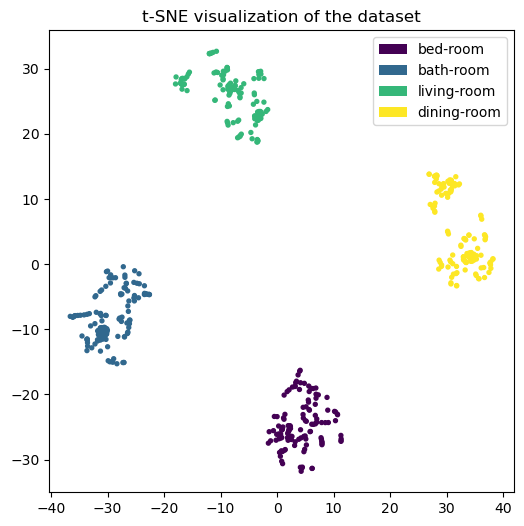

In [6]:
# extract the ground truth labels
labels = dataset.values("ground_truth.label")

# create color map for visualization
label_to_id_map = {label: i for i, label in enumerate(set(labels))}
label_ids = [label_to_id_map[label] for label in labels]

# sample colors from the tab10 colormap
colormap = plt.cm.viridis(np.linspace(0, 1, len(set(labels))))

# assign colors to every point
pt_colors = [colormap[label_id] for label_id in label_ids]

plt.figure(figsize=(6, 6))
plt.title("t-SNE visualization of the dataset")
plt.scatter(results.points[:, 0], results.points[:, 1], c=pt_colors, s=8)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in colormap]
handles = [plt.bar([0], [0], color=c) for c in colormap]
plt.legend(handles, label_to_id_map.keys(), loc='upper right')
plt.show()

## Sample images

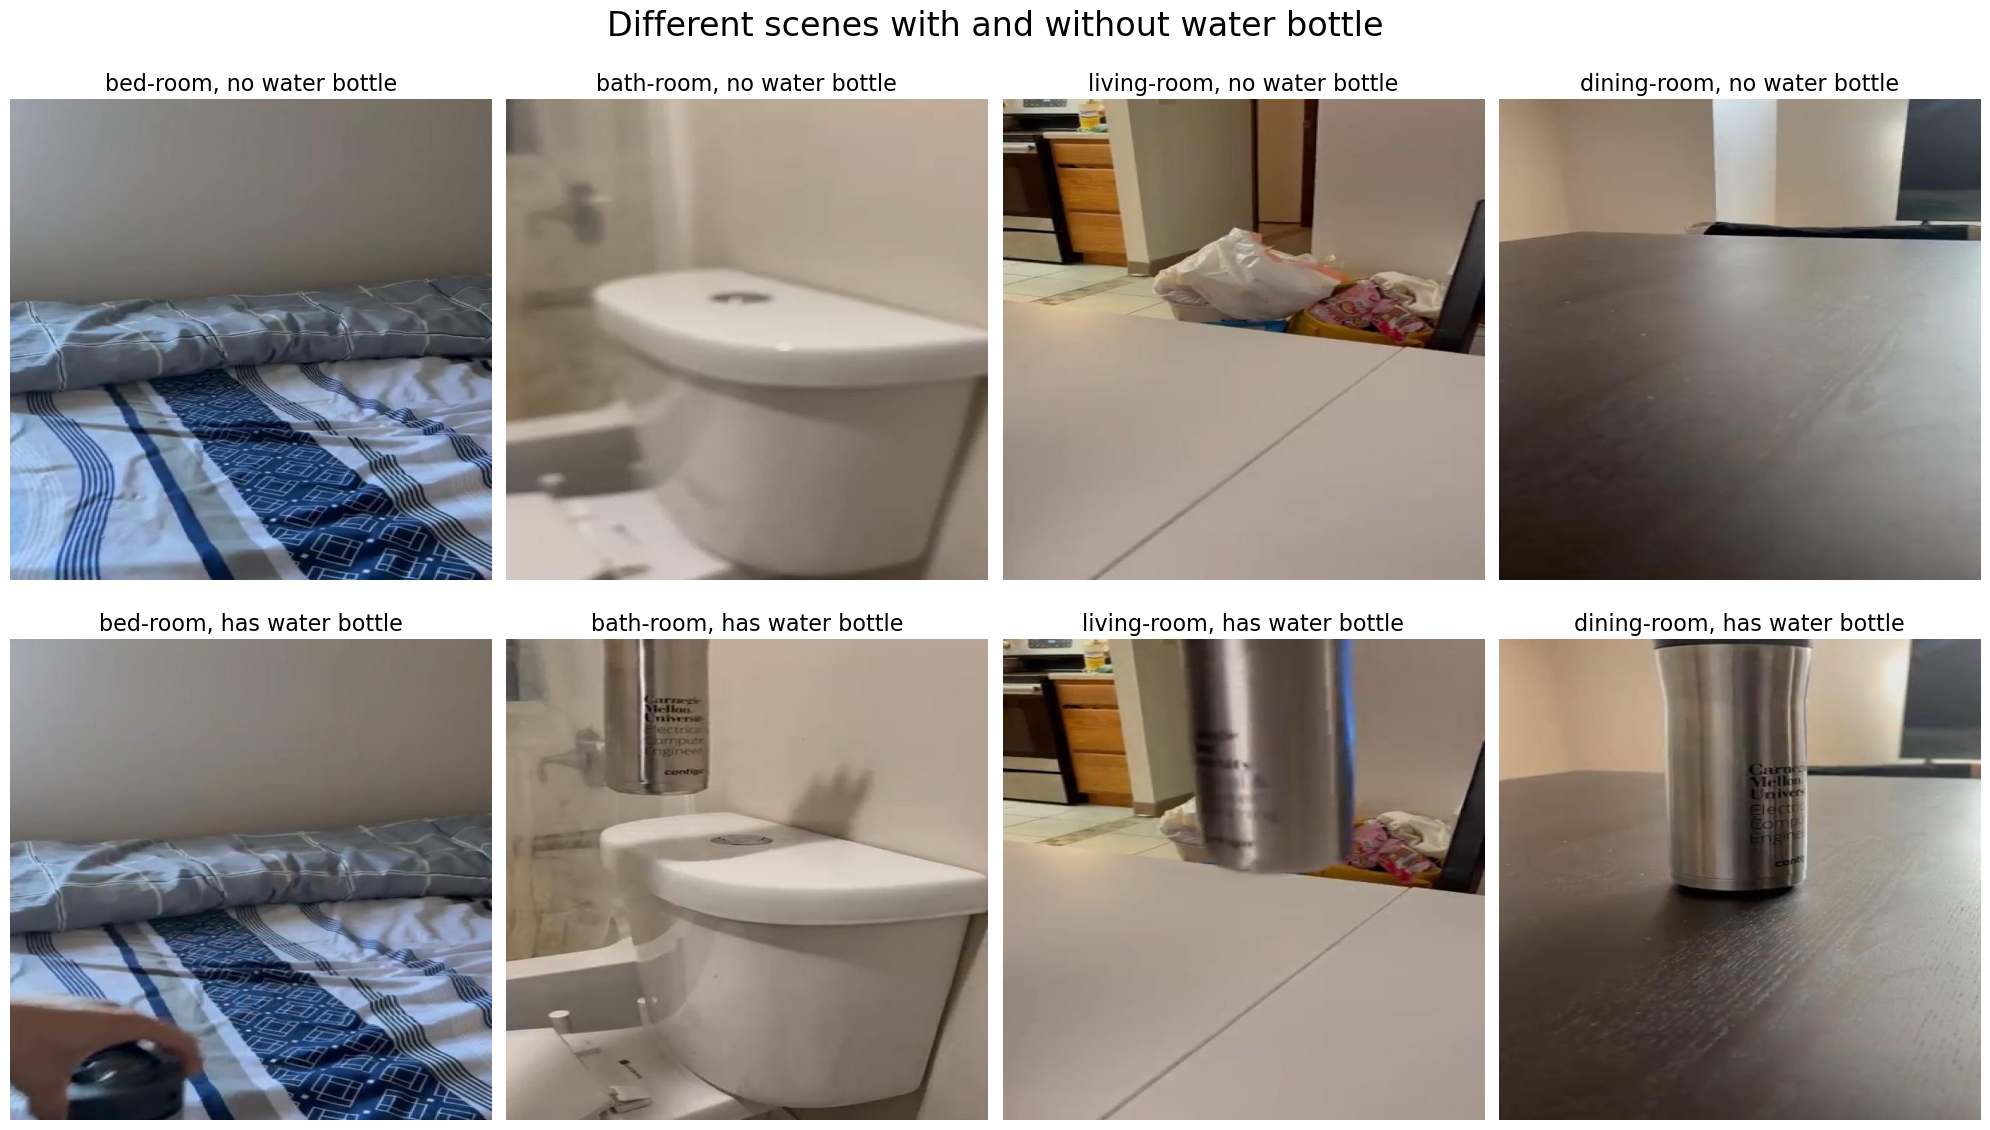

In [7]:
ds_w_bottle = dataset.match({'detections': {'$exists': True}})
ds_wo_bottle = dataset.match({'detections': {'$exists': False}})

fig, ax = plt.subplots(2, 4, figsize=(20, 12), tight_layout=True)
fig.suptitle("Different scenes with and without water bottle", fontsize=24)
classes = set(ds_w_bottle.values("ground_truth.label"))
for i, ds in enumerate([ds_wo_bottle, ds_w_bottle]):
    for j, class_name in enumerate(classes):
        class_sample = ds.match({'ground_truth.label': class_name}).take(1)
        fp = class_sample.values("filepath")[0]
        img = Image.open(fp)
        ax[i, j].imshow(img)
        ax[i, j].set_title(f"{class_name}, {'has' if i else 'no'} water bottle", fontsize=16)
        ax[i, j].axis('off')

plt.show()